In [70]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


In [71]:

#Choosing which years/files to read
el_csv_files = ["Day-ahead Prices_202301010000-202401010000.csv"]
electricity_df = pd.DataFrame()
start_date = datetime(year = 2023, month = 1, day=1, hour=0, minute=0)
end_date = datetime(year=2023, month = 11, day = 3)

#Processing electricity prices

for filename in el_csv_files:
    process_df = pd.read_csv(filename)
    electricity_df = pd.concat([electricity_df,process_df])

electricity_df = electricity_df[electricity_df["Day-ahead Price [EUR/MWh]"] != "-"].drop(labels = "BZN|CH", axis = 1)
electricity_df[['time_start','time_stop']] = electricity_df['MTU (CET/CEST)'].str.split(' - ',expand=True)
electricity_df["time_start"] = pd.to_datetime(electricity_df["time_start"], format = "%d.%m.%Y %H:%M")
electricity_df["time_stop"] = pd.to_datetime(electricity_df["time_stop"], format = "%d.%m.%Y %H:%M")
electricity_df["Day-ahead Price [EUR/MWh]"] = pd.to_numeric(electricity_df["Day-ahead Price [EUR/MWh]"])
    

interval_size_int = 4
interval_size = pd.Timedelta(hours=interval_size_int)

electricity_df["average_electricity_price [EUR/MW]"] = pd.Series()
prices_series = pd.Series()
date_iterator = start_date
while date_iterator < end_date:
    df = electricity_df [(electricity_df["time_start"] >= date_iterator) & (electricity_df["time_start"]< date_iterator + interval_size)]
    #Finding the average 4 hour price in EUR/MW
    avg_price = df["Day-ahead Price [EUR/MWh]"].sum()
    indices = list(df.index.values)
    electricity_df.loc[indices[0]:indices[-1],"average_electricity_price [EUR/MW]"] = avg_price 
    date_iterator = date_iterator+interval_size
electricity_df = electricity_df[electricity_df["time_start"].dt.hour%4 ==0].drop(labels = ["MTU (CET/CEST)", "Day-ahead Price [EUR/MWh]","time_stop", "Currency"], axis =1)
electricity_df

,time_start,average_electricity_price [EUR/MW]
0,2023-01-01 00:00:00,-18.92
4,2023-01-01 04:00:00,-39.85
8,2023-01-01 08:00:00,-7.04
12,2023-01-01 12:00:00,14.76
16,2023-01-01 16:00:00,119.95
...,...,...
7325,2023-11-02 04:00:00,180.58
7329,2023-11-02 08:00:00,260.94
7333,2023-11-02 12:00:00,254.87
7337,2023-11-02 16:00:00,364.75


In [79]:
#processing ancillary bids to find average bid, max bid, and min bid per 4-hour session

ancillary_df = pd.DataFrame()

an_csv_files = ["2023-PRL-SRL-TRL-Ergebnis.csv"]
ancillary_df = pd.DataFrame()


for filename in an_csv_files:
    process_df = pd.read_csv(filename, sep = ";", low_memory=False)
    ancillary_df = pd.concat([ancillary_df,process_df])
    
#specifying and filtering by ancillary service type
ancillary_type = "PRL"
ancillary_df = ancillary_df[ancillary_df["Ausschreibung"].str[0:3] == ancillary_type]

#ancillary_df = ancillary_df.apply(lambda col: pd.to_numeric(col, downcast= 'float', errors = "ignore"), axis = 1)

day = ancillary_df["Ausschreibung"].str[-8:]
time = ancillary_df["Beschreibung"].str[-len("00:00 bis 04:00"):]
time_string = day + " " + time.str[0:5]
ancillary_df["time_start"] = pd.to_datetime(time_string, format = "%y_%m_%d %H:%M")



#We see by unhashing the line below that volume that cannot be parted is relatively small so we can look away from that in the first place
#print(ancillary_df[ancillary_df["Teilbarkeit"] != "Ja"]["Angebotenes Volumen"].sum()/ancillary_df["Angebotenes Volumen"].sum())


#We are at the moment only keeping the 'Leisungspreis' out of the prices
ancillary_df.drop(columns=ancillary_df.columns[:4],axis=1, inplace=True)
ancillary_df.drop(columns=ancillary_df.columns[4:8], axis = 1, inplace=True)
ancillary_df.drop(columns = ancillary_df.columns[5:7],axis = 1,inplace = True)
#ancillary_df.drop(columns=ancillary_df.columns[])

#Unhash line below to get only bids in Switzerland
#ancillary_df = ancillary_df[ancillary_df["Land"] == "CH"]

#Renaming columns
unit_column_names = ancillary_df[ancillary_df.columns[1::2]].values[0]
new_column_names = ["volume_sold ["+ str(unit_column_names[0]) + "]","ancillary_price [" + str(unit_column_names[1])+"]", "country", "divisibility"]
ancillary_df.drop(columns=ancillary_df.columns[1:4:2], axis =1, inplace=True)
ancillary_df = ancillary_df.rename(columns=dict(zip(["Zugesprochenes Volumen","Leistungspreis","Land","Teilbarkeit"],new_column_names)))

#Defining a capacity for the powerplant to filter the dataframe
capacity = 10


ancillary_df = ancillary_df.groupby(by = ["time_start","ancillary_price [EUR/MW]","divisibility"], as_index = False)["volume_sold [MW]"].sum()
ancillary_df = ancillary_df.merge(right = electricity_df, on="time_start").sort_values("ancillary_price [EUR/MW]",ascending = False).sort_values("time_start")
ancillary_df

,time_start,ancillary_price [EUR/MW],divisibility,volume_sold [MW],average_electricity_price [EUR/MW]
0,2023-01-01 00:00:00,0.00,Ja,198,-18.92
147,2023-01-01 00:00:00,120.91,Ja,1,-18.92
26,2023-01-01 00:00:00,2.00,Ja,23,-18.92
146,2023-01-01 00:00:00,120.37,Ja,1,-18.92
52,2023-01-01 00:00:00,3.54,Ja,5,-18.92
...,...,...,...,...,...
264507,2023-11-02 20:00:00,3.47,Ja,14,253.04
264569,2023-11-02 20:00:00,18.60,Ja,3,253.04
264447,2023-11-02 20:00:00,0.36,Ja,7,253.04
264584,2023-11-02 20:00:00,27.02,Ja,1,253.04


In [80]:
#calculating average price 2022
#TODO: find average prices
#make algorithm to optimize choicemakig
#graph together ancillary price and electricity price
#Whats the difference between all the prices??



In [128]:


def average_best_ancillary_prices(volume, ancillary_df):
    '''
        volume: float
        ancillary_df: dataframe formatted as the corresponding dataframes above
    '''
    ancillary_df = ancillary_df.sort_values(by = ["time_start","ancillary_price [EUR/MW]"], ascending = [True,False])
    ancillary_df["cumsum"] = ancillary_df.groupby("time_start", as_index=False)["volume_sold [MW]"].cumsum()

    ancillary_df.loc[(ancillary_df["cumsum"] > volume) & (ancillary_df["cumsum"]-ancillary_df["volume_sold [MW]"] < volume),"volume_sold [MW]"] = ancillary_df["volume_sold [MW]"] - (ancillary_df["cumsum"]-volume)
    ancillary_df["cumsum"] = ancillary_df.groupby("time_start", as_index=False)["volume_sold [MW]"].cumsum()
    ancillary_df = ancillary_df[ancillary_df["cumsum"] <= volume] 

    #calculating weighted average of the highest ancillary prices

    ancillary_df["weight"] = ancillary_df["ancillary_price [EUR/MW]"]*ancillary_df["volume_sold [MW]"]
    result_df = pd.DataFrame()
    result_df["average_best_ancillary_price [EUR/MW]"] = ancillary_df.groupby("time_start").sum()["weight"]/volume
    result_df["average_electricity_price [EUR/MW]"] = ancillary_df.groupby("time_start").first()["average_electricity_price [EUR/MW]"]
    
    return result_df.reset_index()
    

In [131]:
result_df = average_best_ancillary_prices(30,ancillary_df=ancillary_df)

In [132]:
# Single (existing example) plant
#maximal capacity and minimal capacity
# reservoar: assume full once and must be used up until the end of the year
    #Use graph as reference
# run of river: infinite reservoar
# run for every day
# graph of capacity of electricity production/ancillary service

<Axes: xlabel='time_start'>

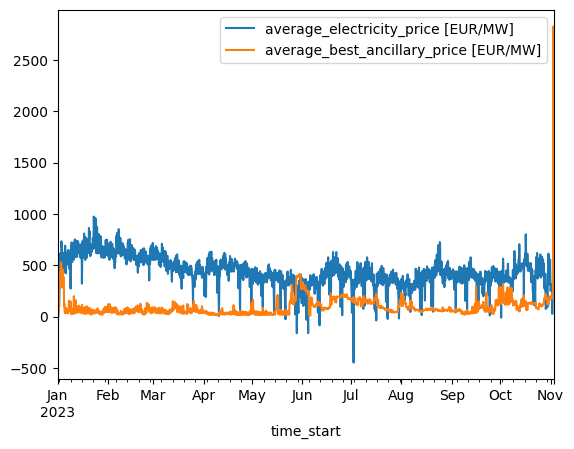

In [135]:
#plotting
ax = result_df.plot(x = "time_start", y = "average_electricity_price [EUR/MW]")
result_df.plot(ax = ax,x = "time_start",y = "average_best_ancillary_price [EUR/MW]")